In [ ]:
#mount google drive with google colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# locate google drive folder
%cd gdrive/MyDrive/zzzzz/
!ls

/content/gdrive/MyDrive/zzzzz
data3.csv  kddcup.data_10_percent  logs  model.png


In [ ]:
# !pip uninstall tensorflow

In [ ]:
# !pip install tensorflow-gpu

In [ ]:
# import tensorflow and check version
import tensorflow as tf
tf.__version__

'2.4.1'

In [ ]:
# Check GPU library from tensorflow
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.gpu_device_name()

Num GPUs Available:  1


'/device:GPU:0'

In [ ]:
#check device library
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4379312929270530042, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14674281152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14248289436571062092
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
#request for URL where data set is
# !curl -O https://datahub.io/machine-learning/kddcup99/r/kddcup99_zip.zip
# !curl -O http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz
!curl -O http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2094k  100 2094k    0     0  2252k      0 --:--:-- --:--:-- --:--:-- 2249k


In [ ]:
#unzip the data set 
!gzip -d kddcup.data_10_percent.gz
# !gzip -d kddcup.data.gz
!ls

gzip: kddcup.data_10_percent already exists; do you wish to overwrite (y or n)? n
	not overwritten
data3.csv  kddcup.data_10_percent  kddcup.data_10_percent.gz  logs  model.png


In [ ]:
#convert data set to csv format
import csv

items = ('duration', 'protocol_type', 'service', 'src_bytes', 'dst_bytes', 'flag', 'land', 'wrong_fragment',
         'urgent','hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
         'num_root', 'num_file_creations','num_shells', 'num_access_files', 'num_outbound_cmds', 'is_hot_login',
         'is_guest_login','count', 'serror_rate', 'rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_count',
         'srv_serror_rate', 'srv_rerror_rate', 'srv_diff_host_rate','unknown_data1','unknown_data2','unknown_data3',
         'unknown_data4','unknown_data5','unknown_data6','unknown_data7','unknown_data8','unknown_data9',
         'unknown_data10','results')


with open ("kddcup.data_10_percent",'r') as file:
    stripped = (line.strip() for line in file)
    lines = (line.split(",") for line in stripped if line)
    with open ("data3.csv",'w', newline='') as out_file:
        writer = csv.writer(out_file)
        writer.writerow(items)
        writer.writerows(lines)

In [ ]:
#import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#assign binary values for inputs
dataframe = pd.read_csv('data3.csv')

dataframe["results"]= dataframe["results"].replace('normal.'        ,0)
dataframe["results"]= dataframe["results"].replace('spy.'            ,1)
dataframe["results"]= dataframe["results"].replace('warezmaster.'    ,1)
dataframe["results"]= dataframe["results"].replace('loadmodule.'     ,1)
dataframe["results"]= dataframe["results"].replace('ipsweep.'        ,1) #1247
dataframe["results"]= dataframe["results"].replace('guess_passwd.'   ,1)
dataframe["results"]= dataframe["results"].replace('back.'           ,1) #2203
dataframe["results"]= dataframe["results"].replace('pod.'            ,1)
dataframe["results"]= dataframe["results"].replace('land.'           ,1)
dataframe["results"]= dataframe["results"].replace('ftp_write.'      ,1)
dataframe["results"]= dataframe["results"].replace('rootkit.'        ,1)
dataframe["results"]= dataframe["results"].replace('teardrop.'       ,1) #979
dataframe["results"]= dataframe["results"].replace('portsweep.'      ,1) #1024
dataframe["results"]= dataframe["results"].replace('smurf.'          ,1) #280790
dataframe["results"]= dataframe["results"].replace('imap.'           ,1)
dataframe["results"]= dataframe["results"].replace('buffer_overflow.',1)
dataframe["results"]= dataframe["results"].replace('phf.'            ,1)
dataframe["results"]= dataframe["results"].replace('perl.'           ,1)
dataframe["results"]= dataframe["results"].replace('nmap.'           ,1)
dataframe["results"]= dataframe["results"].replace('satan.'          ,1) #1589
dataframe["results"]= dataframe["results"].replace('multihop.'       ,1)
dataframe["results"]= dataframe["results"].replace('warezclient.'    ,1) #1020
dataframe["results"]= dataframe["results"].replace('neptune.'        ,1) #107201

dataframe.dropna()



#print first five rows of dataset
print(dataframe.shape)
dataframe.head()

(494021, 42)


,duration,protocol_type,service,src_bytes,dst_bytes,flag,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_hot_login,is_guest_login,count,serror_rate,rerror_rate,same_srv_rate,diff_srv_rate,srv_count,srv_serror_rate,srv_rerror_rate,srv_diff_host_rate,unknown_data1,unknown_data2,unknown_data3,unknown_data4,unknown_data5,unknown_data6,unknown_data7,unknown_data8,unknown_data9,unknown_data10,results
0,0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,0
1,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0
2,0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
3,0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
4,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
#define train data for 80% and randomly testing for 20%
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

In [ ]:
#define labels , validation data and train data
new_labels1 = []
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("results")

    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)
    
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)


Input: {'duration': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'protocol_type': <tf.Tensor: shape=(), dtype=string, numpy=b'tcp'>, 'service': <tf.Tensor: shape=(), dtype=string, numpy=b'private'>, 'src_bytes': <tf.Tensor: shape=(), dtype=string, numpy=b'REJ'>, 'dst_bytes': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'flag': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'land': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'wrong_fragment': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'urgent': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'hot': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'num_failed_logins': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'logged_in': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'num_compromised': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'root_shell': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'su_attempted': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'num_root': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'num_file_creations': <tf.Tensor: shap

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
#import encode functions
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.layers.experimental.preprocessing import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_string_categorical_feature(feature, name, dataset):
    index = StringLookup()

    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    index.adapt(feature_ds)

    encoded_feature = index(feature)

    encoder = CategoryEncoding(output_mode="binary")

    feature_ds = feature_ds.map(index)

    encoder.adapt(feature_ds)

    encoded_feature = encoder(encoded_feature)
    return encoded_feature


def encode_integer_categorical_feature(feature, name, dataset):
    encoder = CategoryEncoding(output_mode="binary")

    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    encoder.adapt(feature_ds)

    encoded_feature = encoder(feature)
    return encoded_feature

In [ ]:
#assign features in dataset as inputs for neural network
duration = keras.Input(shape=(1,), name="duration")
protocol_type = keras.Input(shape=(1,), name="protocol_type", dtype="string")
service = keras.Input(shape=(1,), name="service", dtype="string")
src_bytes = keras.Input(shape=(1,), name="src_bytes", dtype="string")
dst_bytes = keras.Input(shape=(1,), name="dst_bytes")
flag = keras.Input(shape=(1,), name="flag")
land = keras.Input(shape=(1,), name="land")
wrong_fragment = keras.Input(shape=(1,), name="wrong_fragment")
urgent = keras.Input(shape=(1,), name="urgent")
hot = keras.Input(shape=(1,), name="hot")
num_failed_logins = keras.Input(shape=(1,), name="num_failed_logins")
logged_in = keras.Input(shape=(1,), name="logged_in")
num_compromised = keras.Input(shape=(1,), name="num_compromised")
root_shell = keras.Input(shape=(1,), name="root_shell")
su_attempted = keras.Input(shape=(1,), name="su_attempted")
num_root = keras.Input(shape=(1,), name="num_root")
num_file_creations = keras.Input(shape=(1,), name="num_file_creations")
num_shells = keras.Input(shape=(1,), name="num_shells")
num_access_files = keras.Input(shape=(1,), name="num_access_files")
num_outbound_cmds = keras.Input(shape=(1,), name="num_outbound_cmds")
is_hot_login = keras.Input(shape=(1,), name="is_hot_login")
is_guest_login = keras.Input(shape=(1,), name="is_guest_login")
count = keras.Input(shape=(1,), name="count")
serror_rate = keras.Input(shape=(1,), name="serror_rate")
rerror_rate = keras.Input(shape=(1,), name="rerror_rate")
same_srv_rate = keras.Input(shape=(1,), name="same_srv_rate")
diff_srv_rate = keras.Input(shape=(1,), name="diff_srv_rate")
srv_count = keras.Input(shape=(1,), name="srv_count")
srv_serror_rate = keras.Input(shape=(1,), name="srv_serror_rate")
srv_rerror_rate = keras.Input(shape=(1,), name="srv_rerror_rate")
srv_diff_host_rate = keras.Input(shape=(1,), name="srv_diff_host_rate")
# unknown_data1 = keras.Input(shape=(1,), name="unknown_data1")
# unknown_data2 = keras.Input(shape=(1,), name="unknown_data2")
# unknown_data3 = keras.Input(shape=(1,), name="unknown_data3")
# unknown_data4 = keras.Input(shape=(1,), name="unknown_data4")
# unknown_data5 = keras.Input(shape=(1,), name="unknown_data5")
# unknown_data6 = keras.Input(shape=(1,), name="unknown_data6")
# unknown_data7 = keras.Input(shape=(1,), name="unknown_data7")
# unknown_data8 = keras.Input(shape=(1,), name="unknown_data8")
# unknown_data9 = keras.Input(shape=(1,), name="unknown_data9")
# unknown_data10 = keras.Input(shape=(1,), name="unknown_data10")

#define all input values
all_inputs = [duration,
              protocol_type, 
              service, 
              src_bytes, 
              dst_bytes, 
              flag, 
              land, 
              wrong_fragment,
              urgent,
              hot, 
              num_failed_logins, 
              logged_in, 
              num_compromised, 
              root_shell, 
              su_attempted, 
              num_root, 
              num_file_creations,
              num_shells, 
              num_access_files, 
              num_outbound_cmds, 
              is_hot_login, 
              is_guest_login,
              count, 
              serror_rate, 
              rerror_rate, 
              same_srv_rate, 
              diff_srv_rate, 
              srv_count, 
              srv_serror_rate, 
              srv_rerror_rate, 
              srv_diff_host_rate,
              # unknown_data1,
              # unknown_data2,
              # unknown_data3,
              # unknown_data4,
              # unknown_data5,
              # unknown_data6,
              # unknown_data7,
              # unknown_data8,
              # unknown_data9,
              # unknown_data10
             ]

In [ ]:
#encode all inputs to train model
duration_encoded = encode_numerical_feature(duration, "duration", train_ds)

protocol_type_encoded = encode_string_categorical_feature(protocol_type,"protocol_type", train_ds)
service_encoded = encode_string_categorical_feature(service, "service", train_ds)
src_bytes_encoded = encode_string_categorical_feature(src_bytes,"src_bytes", train_ds)


dst_bytes_encoded           = encode_numerical_feature(dst_bytes,"dst_bytes", train_ds)
flag_encoded                = encode_numerical_feature(flag, "flag", train_ds)
land_encoded                = encode_numerical_feature(land, "land", train_ds)
wrong_fragment_encoded      = encode_numerical_feature(wrong_fragment, "wrong_fragment", train_ds)
urgent_encoded              = encode_numerical_feature(urgent, "urgent", train_ds)
hot_encoded                 = encode_numerical_feature(hot, "hot", train_ds)
num_failed_logins_encoded   = encode_numerical_feature(num_failed_logins, "num_failed_logins", train_ds)
logged_in_encoded           = encode_numerical_feature(logged_in, "logged_in", train_ds)
num_compromised_encoded     = encode_numerical_feature(num_compromised, "num_compromised", train_ds)
root_shell_encoded          = encode_numerical_feature(root_shell, "root_shell", train_ds)
su_attempted_encoded        = encode_numerical_feature(su_attempted, "su_attempted", train_ds)
num_root_encoded            = encode_numerical_feature(num_root, "num_root", train_ds)
num_file_creations_encoded  = encode_numerical_feature(num_file_creations, "num_file_creations", train_ds)
num_shells_encoded          = encode_numerical_feature(num_shells, "num_shells", train_ds)
num_access_files_encoded    = encode_numerical_feature(num_access_files, "num_access_files", train_ds)
num_outbound_cmds_encoded   = encode_numerical_feature(num_outbound_cmds, "num_outbound_cmds", train_ds)
is_hot_login_encoded        = encode_numerical_feature(is_hot_login, "is_hot_login", train_ds)
is_guest_login_encoded      = encode_numerical_feature(is_guest_login, "is_guest_login", train_ds)
count_encoded               = encode_numerical_feature(count, "count", train_ds)
serror_rate_encoded         = encode_numerical_feature(serror_rate, "serror_rate", train_ds)
rerror_rate_encoded         = encode_numerical_feature(rerror_rate, "rerror_rate", train_ds)
same_srv_rate_encoded       = encode_numerical_feature(same_srv_rate, "same_srv_rate", train_ds)
diff_srv_rate_encoded       = encode_numerical_feature(diff_srv_rate, "diff_srv_rate", train_ds)
srv_count_encoded           = encode_numerical_feature(srv_count, "srv_count", train_ds)
srv_serror_rate_encoded     = encode_numerical_feature(srv_serror_rate, "srv_serror_rate", train_ds)
srv_rerror_rate_encoded     = encode_numerical_feature(srv_rerror_rate, "srv_rerror_rate", train_ds)
srv_diff_host_rate_encoded  = encode_numerical_feature(srv_diff_host_rate, "srv_diff_host_rate", train_ds)
# unknown_data1_encoded = encode_numerical_feature(unknown_data1, "unknown_data1", train_ds)
# unknown_data2_encoded = encode_numerical_feature(unknown_data2, "unknown_data2", train_ds)
# unknown_data3_encoded = encode_numerical_feature(unknown_data3, "unknown_data3", train_ds)
# unknown_data4_encoded = encode_numerical_feature(unknown_data4, "unknown_data4", train_ds)
# unknown_data5_encoded = encode_numerical_feature(unknown_data5, "unknown_data5", train_ds)
# unknown_data6_encoded = encode_numerical_feature(unknown_data6, "unknown_data6", train_ds)
# unknown_data7_encoded = encode_numerical_feature(unknown_data7, "unknown_data7", train_ds)
# unknown_data8_encoded = encode_numerical_feature(unknown_data8, "unknown_data8", train_ds)
# unknown_data9_encoded = encode_numerical_feature(unknown_data9, "unknown_data9", train_ds)
# unknown_data10_encoded = encode_numerical_feature(unknown_data10, "unknown_data10", train_ds)


#encoded inputs
all_features = layers.concatenate (
    [
        duration_encoded,
        protocol_type_encoded, 
        service_encoded, 
        src_bytes_encoded, 
        dst_bytes_encoded,
        flag_encoded, 
        land_encoded, 
        wrong_fragment_encoded,
        urgent_encoded,
        hot_encoded, 
        num_failed_logins_encoded, 
        logged_in_encoded, 
        num_compromised_encoded, 
        root_shell_encoded, 
        su_attempted_encoded, 
        num_root_encoded, 
        num_file_creations_encoded,
        num_shells_encoded, 
        num_access_files_encoded, 
        num_outbound_cmds_encoded, 
        is_hot_login_encoded, 
        is_guest_login_encoded,
        count_encoded, 
        serror_rate_encoded, 
        rerror_rate_encoded, 
        same_srv_rate_encoded, 
        diff_srv_rate_encoded, 
        srv_count_encoded, 
        srv_serror_rate_encoded, 
        srv_rerror_rate_encoded, 
        srv_diff_host_rate_encoded,
        # unknown_data1_encoded,
        # unknown_data2_encoded,
        # unknown_data3_encoded,
        # unknown_data4_encoded,
        # unknown_data5_encoded,
        # unknown_data6_encoded,
        # unknown_data7_encoded,
        # unknown_data8_encoded,
        # unknown_data9_encoded,
        # unknown_data10_encoded,

    ]
)

In [ ]:
#import optimizer
from tensorflow.keras.optimizers import Adam

#define hidden layers
x = layers.Dense(128, activation="relu")(all_features)
x = layers.Dropout(0.1)(x)
x1 = layers.Dense(512, activation="relu")(x)
x1 = layers.Dropout(0.5)(x1)
x2 = layers.Dense(512, activation="relu")(x1)
x2 = layers.Dropout(0.3)(x2)
x3 = layers.Dense(512, activation="relu")(x2)
x3 = layers.Dense(124, activation="relu")(x3)
x4 = layers.Dense(124, activation="relu")(x3)
x4 = layers.Dropout(0.3)(x4)


#output layer
output = layers.Dense(1, activation="sigmoid")(x4)
#settting up model
model = keras.Model(all_inputs, output)
#compiling model (seeting up optimizer and learning rate the loss function and metrics)
model.compile(optimizer=Adam(learning_rate=0.0000001), loss='binary_crossentropy', metrics=['accuracy'])


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
protocol_type (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
service (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
src_bytes (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
duration (InputLayer)           [(None, 1)]          0                                            
______________________________________________________________________________________________

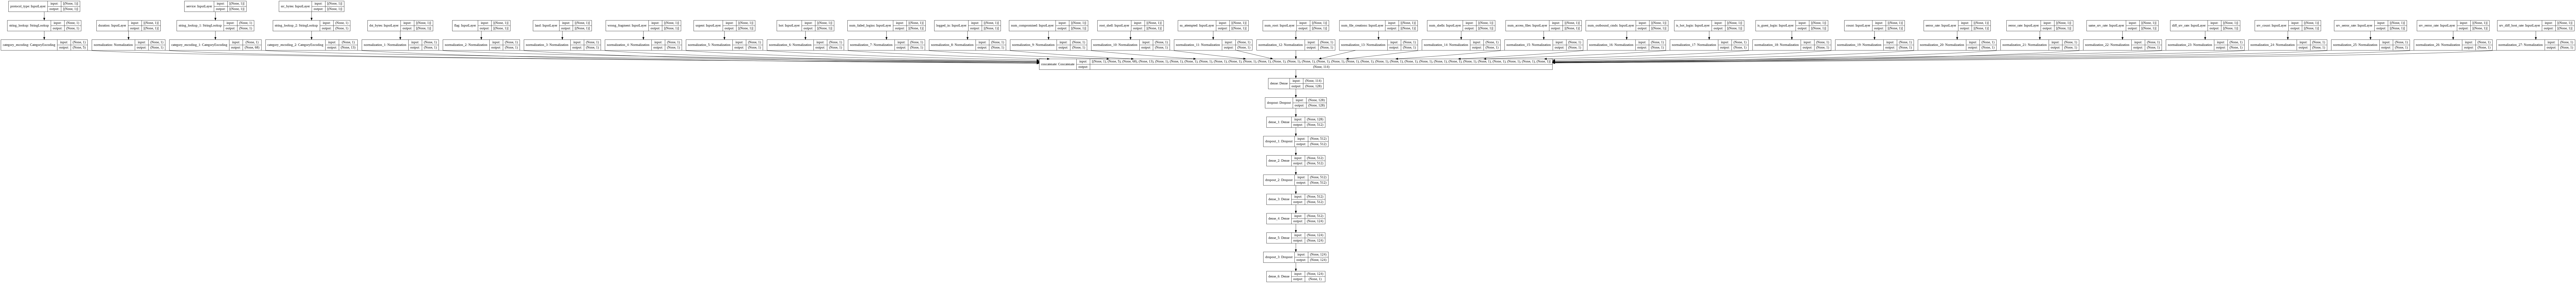

In [ ]:
#plot model summary
model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
import datetime, os

#load data to tensorboard and implement callback function to get logs
%load_ext tensorboard

#train data by 250 epochs and assign batch size as 128
batch_size = 128
epochs = 250


logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=0,write_images=False,)

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),

            ]

model.fit(train_ds, epochs=epochs, validation_data=val_ds,callbacks=[tensorboard_callback])

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/250


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['unknown_data1', 'unknown_data2', 'unknown_data3', 'unknown_data4', 'unknown_data5', 'unknown_data6', 'unknown_data7', 'unknown_data8', 'unknown_data9', 'unknown_data10'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


12351/12351 [==============================] - 113s 9ms/step - loss: 0.7068 - accuracy: 0.3910 - val_loss: 0.6347 - val_accuracy: 0.8035
Epoch 2/250
12351/12351 [==============================] - 110s 9ms/step - loss: 0.6187 - accuracy: 0.8060 - val_loss: 0.5499 - val_accuracy: 0.8035
Epoch 3/250
12351/12351 [==============================] - 109s 9ms/step - loss: 0.5316 - accuracy: 0.8048 - val_loss: 0.4526 - val_accuracy: 0.8035
Epoch 4/250
12351/12351 [==============================] - 109s 9ms/step - loss: 0.4479 - accuracy: 0.8023 - val_loss: 0.3496 - val_accuracy: 0.8173
Epoch 5/250
12351/12351 [==============================] - 109s 9ms/step - loss: 0.3620 - accuracy: 0.8172 - val_loss: 0.2622 - val_accuracy: 0.9470
Epoch 6/250
12351/12351 [==============================] - 109s 9ms/step - loss: 0.2880 - accuracy: 0.8909 - val_loss: 0.1962 - val_accuracy: 0.9675
Epoch 7/250
12351/12351 [==============================] - 108s 9ms/step - loss: 0.2222 - accuracy: 0.9538 - val_loss:

In [ ]:
!ls

data3.csv  kddcup.data_10_percent     logs
gdrive	   kddcup.data_10_percent.gz  model.png


In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
#save and load model
modle.save('gdrive/MyDrive/zzzzz/save_model')
modle.save_weights('gdrive/MyDrive/zzzzz/save_model')

#new_model = tf.keras.models.load_model('save_model')